# Classifying the MNIST Dataset

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random as rd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
SIZE = 28
LABELS = 10
CHANNELS = 1
BREAKS = 50

---
## Visualizer Functions
These are some helper functions

In [3]:
def digits(data, labels, predictions=None):
    fig, ax = plt.subplots(3, 10, figsize = (20, 8))
    for i in xrange(3):
        for j in xrange(10):
            x = rd.randint(0, len(data))
            ax[i,j].matshow(data.reshape(-1, SIZE, SIZE)[x], cmap=cm.gray_r)
            ax[i,j].set_title("Label: {}".format(labels[x]))
            ax[i,j].axis('off')
    plt.show()

In [4]:
def plotter(history):
    at, av, lt, lv = zip(*history)
    fig = plt.figure(figsize=(15, 8)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

    ax1.plot(np.arange(0, len(at), 1), at,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(at[-1]))
    ax1.plot(np.arange(0, len(av), 1), av,".-", color='#FFA933', label="Validation: {0:.2f}%".format(av[-1]))
    ax1.grid(True); ax1.legend(loc="lower right"); ax1.set_title("Accuracy per epoch")

    ax2.plot(np.arange(0, len(lt), 1), lt,".-", color='#2A6EA6', label="Training: {0:.2f}".format(lt[-1]))
    ax2.plot(np.arange(0, len(lv), 1), lv,".-", color='#FFA933', label="Validation: {0:.2f}".format(lv[-1]))
    ax2.grid(True); ax2.legend(loc="upper right"); ax2.set_title("Cost per epoch")
    plt.show()

---
## Data Import

In [5]:
pickle_file = '/Users/desiredewaele/Google Drive/Datasets/notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    data = save['data']
    labels = save['labels']
    del save

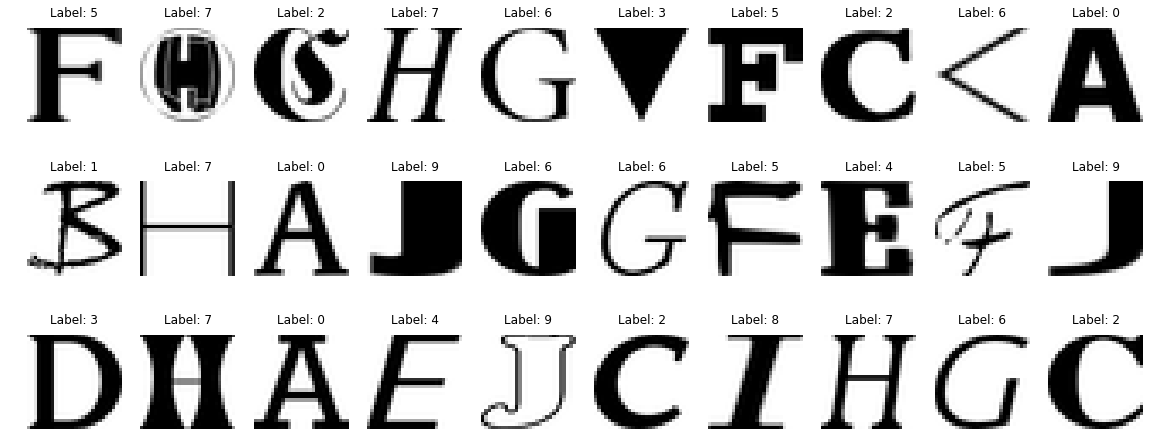

In [6]:
digits(data, labels)

---
## Data Preproccessing
Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [7]:
print('Dataset', data.shape, labels.shape)

('Dataset', (220000, 28, 28), (220000,))


In [8]:
data = data.reshape(-1, SIZE, SIZE, CHANNELS)
labels = pd.get_dummies(labels).values

In [9]:
print('Dataset', data.shape, labels.shape)

('Dataset', (220000, 28, 28, 1), (220000, 10))


In [10]:
from sklearn.model_selection import train_test_split
data, testX, labels, testY = train_test_split(data, labels, test_size=10000, random_state=100)
trainX, validX, trainY, validY = train_test_split(data, labels, test_size=10000, random_state=100)

In [11]:
print('Training set:', trainX.shape, trainY.shape)
print('Validation set:', validX.shape, validY.shape)
print('Testing set:', testX.shape, testY.shape)

('Training set:', (200000, 28, 28, 1), (200000, 10))
('Validation set:', (10000, 28, 28, 1), (10000, 10))
('Testing set:', (10000, 28, 28, 1), (10000, 10))


---
## Convolutional Neural Network 1

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [12]:
BATCH = 16
PATCH = 5
DEPTH = 16
HIDDEN = 64
RATE = 0.05
STEPS = 1001

In [13]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE, SIZE, CHANNELS))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, DEPTH], stddev=0.1))
    w3 = tf.Variable(tf.truncated_normal([SIZE // 4 * SIZE // 4 * DEPTH, HIDDEN], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
    b1 = tf.Variable(tf.zeros([DEPTH]))
    b2 = tf.Variable(tf.constant(1.0, shape=[DEPTH]))
    b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
    b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

    # Model.
    def model(x):
        x = tf.nn.conv2d(x, w1, [1, 2, 2, 1], padding='SAME')
        x = tf.nn.relu(x + b1)
        x = tf.nn.conv2d(x, w2, [1, 2, 2, 1], padding='SAME')
        x = tf.nn.relu(x + b2)
        shape = x.get_shape().as_list()
        x = tf.reshape(x, [-1, shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(x, w3) + b3)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(loss)

    # Predictions and Accuracy.
    predictions = {"classes": tf.argmax(logits, axis=1),"probabilities": tf.nn.softmax(logits)}
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(predictions["classes"], tf.argmax(tfDataY, axis=1)))) * 100

In [14]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX = trainX[offset:(offset + BATCH), :, :, :]
        batchY = trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: batchX, tfDataY: batchY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: batchX, tfDataY: batchY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
            print ".",
    predictions = session.run(predictions, {tfDataX: testX})
    accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    print('\nTest accuracy: %.2f%%' % accuracy)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Test accuracy: 83.02%


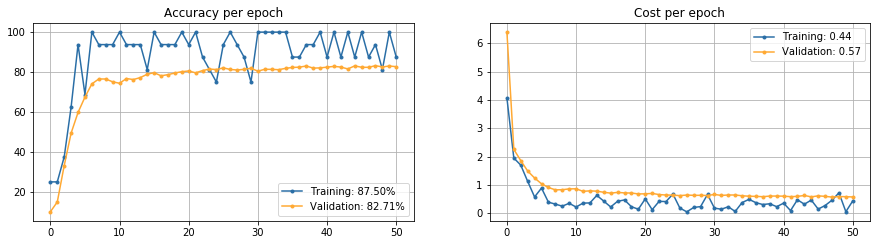

In [15]:
plotter(history)

---
## Convolutional Neural Network 2

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

In [ ]:
BATCH = 16
PATCH = 5
DEPTH = 16
HIDDEN = 64
RATE = 0.05
STEPS = 1001

In [ ]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE, SIZE, CHANNELS))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, DEPTH], stddev=0.1))
    w3 = tf.Variable(tf.truncated_normal([SIZE // 4 * SIZE // 4 * DEPTH, HIDDEN], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
    b1 = tf.Variable(tf.zeros([DEPTH]))
    b2 = tf.Variable(tf.constant(1.0, shape=[DEPTH]))
    b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
    b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))
    
    def model(x):
        # Convolutional layer 1
        x = tf.nn.conv2d(x, w1, [1, 1, 1, 1], padding='SAME') + b1
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        # Convolutional layer 2
        x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME') + b2
        x = tf.nn.relu(x)
        x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        # Two fully conected layers
        shape = x.get_shape().as_list()
        x = tf.reshape(x, [-1, shape[1] * shape[2] * shape[3]])
        x = tf.matmul(x, w3) + b3
        x = tf.nn.relu(x)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(loss)

    # Predictions and Accuracy.
    predictions = {"classes": tf.argmax(logits, axis=1),"probabilities": tf.nn.softmax(logits)}
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(predictions["classes"], tf.argmax(tfDataY, axis=1)))) * 100

In [ ]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX = trainX[offset:(offset + BATCH), :, :, :]
        batchY = trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: batchX, tfDataY: batchY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: batchX, tfDataY: batchY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
            print ".",
    predictions = session.run(predictions, {tfDataX: testX})
    accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    print('\nTest accuracy: %.1f%%' % accuracy)

In [ ]:
plotter(history)

---
## Convolutional Neural Network 3

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

In [ ]:
BATCH = 16
PATCH = 5
DEPTH = 16
HIDDEN = 64
RATE = 0.05
STEPS = 20001

In [ ]:
graph = tf.Graph()
with graph.as_default():

    # Input data.
    tfDataX = tf.placeholder(tf.float32, shape=(None, SIZE, SIZE, CHANNELS))
    tfDataY = tf.placeholder(tf.float32, shape=(None, LABELS))

    # Variables.
    w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
    w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, DEPTH], stddev=0.1))
    size3 = ((SIZE - PATCH + 1) // 2 - PATCH + 1) // 2
    w3 = tf.Variable(tf.truncated_normal([size3 * size3 * DEPTH, HIDDEN], stddev=0.1))
    w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
    
    b1 = tf.Variable(tf.zeros([DEPTH]))
    b2 = tf.Variable(tf.constant(1.0, shape=[DEPTH]))
    b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
    b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))
  
    # Model.
    def model(data):
        x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='VALID') + b1
        x = tf.nn.relu(x)
        x = tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='VALID') + b2
        x = tf.nn.relu(x)
        x = tf.nn.avg_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        shape = x.get_shape().as_list()
        x = tf.reshape(x, [-1, shape[1] * shape[2] * shape[3]])
        x = tf.nn.relu(tf.matmul(x, w3) + b3)
        return tf.matmul(x, w4) + b4
  
    # Training computation.
    logits = model(tfDataX)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tfDataY))
    optimizer = tf.train.GradientDescentOptimizer(RATE).minimize(loss)

    # Predictions and Accuracy.
    predictions = {"classes": tf.argmax(logits, axis=1),"probabilities": tf.nn.softmax(logits)}
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(predictions["classes"], tf.argmax(tfDataY, axis=1)))) * 100

In [ ]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    history = []
    for step in range(STEPS):
        offset = (step * BATCH) % (trainY.shape[0] - BATCH)
        batchX = trainX[offset:(offset + BATCH), :, :, :]
        batchY = trainY[offset:(offset + BATCH), :]
        session.run(optimizer, {tfDataX: batchX, tfDataY: batchY})
        if(step % (STEPS // BREAKS) == 0):
            lt, at = session.run([loss, accuracy], {tfDataX: batchX, tfDataY: batchY})
            lv, av = session.run([loss, accuracy], {tfDataX: validX, tfDataY: validY})
            history.append((at, av, lt, lv))
            print ".",
    predictions = session.run(predictions, {tfDataX: testX})
    accuracy = session.run(accuracy, {tfDataX: testX, tfDataY: testY})
    print('\nTest accuracy: %.1f%%' % accuracy)

In [ ]:
plotter(history)

## Predictions on Test Set

In [16]:
print(predictions["classes"][0:3])
print(predictions["probabilities"][0:3])

[6 0 3]
[[  2.67988481e-02   7.43628945e-03   2.89457113e-01   1.18705900e-02
    4.61592153e-02   8.45576264e-03   5.06805837e-01   1.82248801e-02
    4.41901125e-02   4.06013317e-02]
 [  9.93614018e-01   1.52957127e-05   2.40416521e-05   2.48785163e-05
    1.47149067e-05   2.62385758e-04   8.96025158e-05   5.75193763e-03
    1.31215842e-04   7.20280004e-05]
 [  2.42698734e-04   2.52760332e-02   1.21733545e-04   9.71066773e-01
    1.49926800e-05   8.21139038e-05   1.07346525e-04   1.42651275e-04
    6.05514739e-04   2.34007207e-03]]


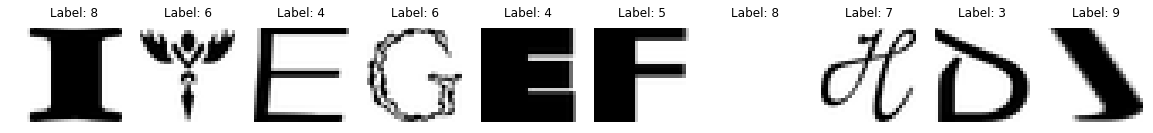

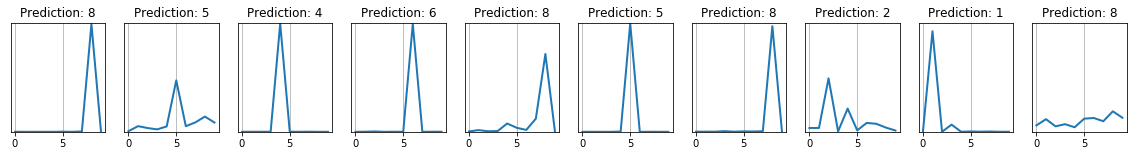

In [17]:
fig1, ax1 = plt.subplots(1, 10, figsize = (20, 2))
fig2, ax2 = plt.subplots(1, 10, figsize = (20, 2))
for t in xrange(10):
    x = rd.randint(0, len(testX))
    ax1[t].matshow(testX.reshape(-1, SIZE, SIZE)[x], cmap=cm.gray_r)
    ax1[t].set_title("Label: {}".format(np.argmax(testY[x])))    
    ax1[t].axis('off')
    ax2[t].plot(predictions["probabilities"][x], lw=2)
    ax2[t].set_title("Prediction: {}".format(predictions["classes"][x]))
    ax2[t].get_yaxis().set_visible(False); ax2[t].set_ylim([0, 1]); ax2[t].grid(True)
plt.show()

In [ ]:
digits(data, labels)